In [81]:
from __future__ import print_function
import pandas as pd
import os
import matplotlib.pyplot as plt

import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torch.utils.data as data
import os
import copy
torch.set_default_tensor_type('torch.DoubleTensor')

import demo_multi
import importlib
importlib.reload(demo_multi)
importlib.reload(plt)
from demo_multi import SplitData, train_validate_test, WeightDataSet, \
    Net, test_regression 

import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('Fa_data.csv')

In [8]:
df.columns

Index(['time(s)', ' Fa_x(N)', ' Fa_y(N)', ' Fa_z(N)', ' x(m)', ' y(m)',
       ' z(m)', ' v_x(m/s)', ' v_y(m/s)', ' v_z(m/s)', ' quaternion_x',
       ' quaternion_y', ' quaternion_z', ' quaternion_w', ' u_1(RPM)',
       ' u_2(RPM)', ' u_3(RPM)', ' u_4(RPM)'],
      dtype='object')

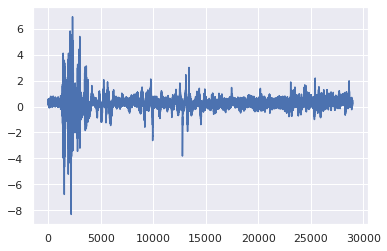

In [9]:
df[' Fa_x(N)'].plot()

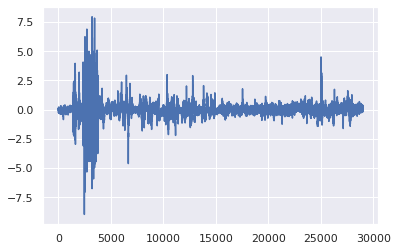

In [10]:
df[' Fa_y(N)'].plot()

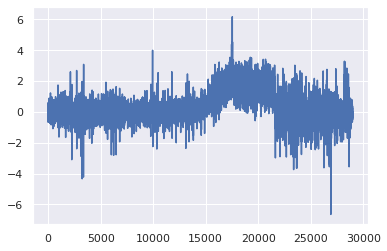

In [11]:
df[' Fa_z(N)'].plot()

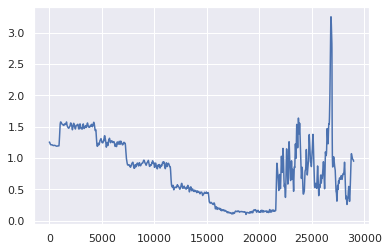

In [12]:
df[' z(m)'].plot()

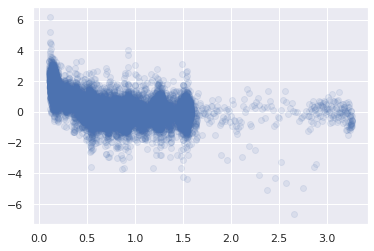

In [13]:
plt.scatter(df[' z(m)'], df[' Fa_z(N)'], alpha=0.1)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
torch.set_default_tensor_type('torch.DoubleTensor')

In [15]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(12, 25)
        self.fc2 = nn.Linear(25, 30)
        self.fc3 = nn.Linear(30, 15)
        self.fc4 = nn.Linear(15, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

def read_weight(filename):
    model_weight = torch.load(filename)
    model = Network()
    model.load_state_dict(model_weight)
    return model

In [16]:
fa_model = read_weight('Fa_net_12_3_full_Lip16.pth')

In [17]:
# state is a 12-d vector
# 0: height, z
# 1,2,3: velocity, \dot{x}, \dot{y}, \dot{z}
# 4,5,6,7: quaternion, qx, qy, qz, qw
# 8,9,10,11: control, u1, u2, u3, u4

# input range and constraints
# 0 <= z <= 1.5
# -1 <= \dot{x,y,z} <= 1 
# qx^2 + qy^2 + qz^2 + qw^2 = 1
# 0 <= u1,u2,u3,u4 <= 1

# *******************************************
# Task 1: learn a 4d -> 3d function
# fix qx,qy,qz,qw = 0,0,0,1
# fix u1,u2,u3,u4 = 0.7,0.7,0.7,0.7
# learn the function (z,\dot{x},\dot{y},\dot{z}) -> fa
def fa_output(fa_model, height, velocity, controls=[0.7] * 4):
    state = np.zeros([1, 12])
    state[0, 0] = height
    state[0, 1:4] = velocity
    state[0, 7] = 1.0
    state[0, 8:12] = controls
    state_torch = torch.from_numpy(state)
    #print(state_torch)
    Fa = fa_model(state_torch)
    return Fa

In [18]:
print(fa_output(fa_model=fa_model, height=0.2, velocity=np.array([0,0,0])))

# *******************************************
# Task 2: learn a 8d -> 3d function
# fix qx,qy,qz,qw = 0,0,0,1
# learn the function (z,\dot{x},\dot{y},\dot{z},u1,u2,u3,u4) -> fa

tensor([[0.2861, 0.0693, 1.3686]], grad_fn=<AddmmBackward>)


In [19]:
dots = np.zeros((300, 3))
for i in range(300):
    a = fa_output(fa_model=fa_model, height=i/100.0, velocity=np.array([0,0,-1]))
    dots[i] = a[0].detach().numpy()

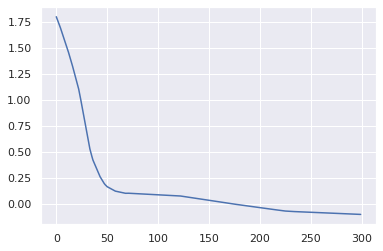

In [20]:
plt.plot(dots[:,2])

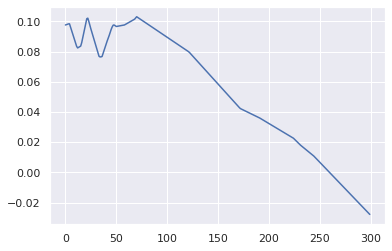

In [21]:
plt.plot(dots[:,1])

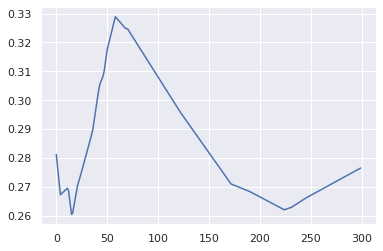

In [22]:
plt.plot(dots[:,0])

In [23]:
np.random.random(4)

array([0.7609592 , 0.61525881, 0.9435133 , 0.50579592])

In [24]:
n_rows = 10000
dots = np.zeros((n_rows, 3))
inputs = np.random.random(n_rows * 4).reshape((n_rows, 4))
inputs[:,0] *= 3
inputs[:,1:] = inputs[:,1:] * 2 - 1
for i, x in enumerate(inputs):
    a = fa_output(fa_model=fa_model, height=x[0],
                  velocity=np.array(x[1:]))
    dots[i] = a[0].detach().numpy()

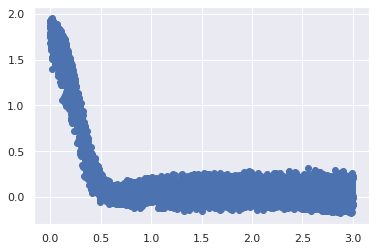

In [25]:
plt.scatter(inputs[:,0], dots[:,2])

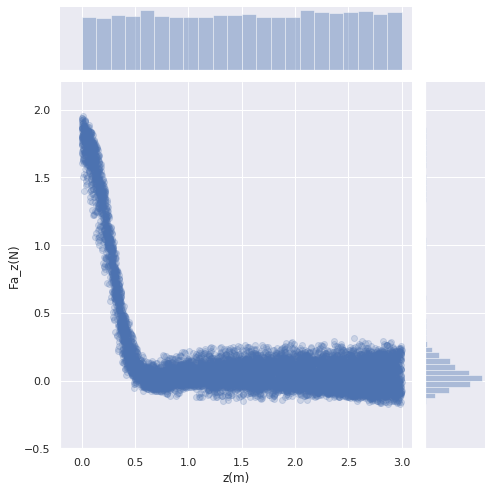

In [29]:
import seaborn as sns
sns.set(style="darkgrid")
syn_df = pd.DataFrame({
    'Fa_z(N)': dots[:, 2],
    'z(m)': inputs[:, 0]
})
# tips = sns.load_dataset("tips")
# g = sns.jointplot("total_bill", "tip", data=tips,
#                   kind="reg", truncate=False,
#                   xlim=(0, 60), ylim=(0, 12),
#                   color="m", height=7)
g = sns.jointplot("z(m)", "Fa_z(N)", data=syn_df,
                  #kind="scatter",
                  xlim=(-0.2, 3.1), ylim=(-0.5, 2.2),
                  color="b", height=7, joint_kws={'alpha': 0.2})

In [30]:
'''
d is the dimension of the last layer of network

'''

d = 10

'''
d_out is the dimension of the output variable

'''

d_out = 3


'''
mean0 and var0 is set according to prior knowledge and will not
affect the result a lot in the no shift case.
However, if there is shift and target data is far from source,
base distribution will dominate the result.

'''

mean0 = np.zeros([1, d_out])
var0 = np.eye(d_out)

In [31]:
class Args:
    pass

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


batch_size = 32
epochs_training = 50
lr = 0.0005
momentum = 0.5
log_interval = 100
lamb = 0.001

args = Args()
args.batch_size = batch_size
args.epochs_training = epochs_training
args.lr = lr
args.momentum = momentum
args.log_interval = log_interval

In [32]:
split_data = SplitData(inputs, dots)

In [33]:
split_data = np.random.permutation(split_data)
train_data = data.Subset(split_data, range(0, int(0.8*len(split_data))))
# 20% test set
test_data = data.Subset(split_data, range(int(0.8*len(split_data)), len(split_data)))

m_train = len(train_data)

# for covariate shift, plug in densities for source data
weight_st = np.ones(m_train)
    
weighted_train = WeightDataSet(train_data, weight_st)
m_test = len(test_data)

# for covariate shift, plug in densities for target data
weight_st = np.ones(m_test)
weighted_test = WeightDataSet(test_data, weight_st)


test_loader = data.DataLoader(weighted_test,
    batch_size=args.batch_size, shuffle=False, **kwargs)

# 10% of training as validation
m_validate = int(0.1*m_train)

validate_loader = data.DataLoader(data.Subset(weighted_train,range(0, m_validate)),
    batch_size=args.batch_size, shuffle=False, **kwargs)

# 10% validation set, note that under shift cases, cannot valiate using training data
train_loader = data.DataLoader(data.Subset(weighted_train, range(m_validate, m_train)),
    batch_size=args.batch_size, shuffle=False, **kwargs)

base_model = Net(4,256, d)
base_model = base_model.to(device)

print("entering training")
model, Myy, Myx, y_pred, y_var, _  = train_validate_test(
    args, args.epochs_training, device, use_cuda, base_model, 
    train_loader, test_loader , validate_loader, lamb)

entering training
Train Epoch: 1 [0/7200 (0%)]
Train Epoch: 1 [3200/7200 (44%)]
Train Epoch: 1 [6400/7200 (89%)]
gradient yy: 1.145913577100575
gradient yx: 0.3141222291611663
Average loss: 0.5601

Train Epoch: 2 [0/7200 (0%)]
Train Epoch: 2 [3200/7200 (44%)]
Train Epoch: 2 [6400/7200 (89%)]
gradient yy: 0.9876900291982986
gradient yx: 0.17943535473172428
Average loss: 0.5489

Train Epoch: 3 [0/7200 (0%)]
Train Epoch: 3 [3200/7200 (44%)]
Train Epoch: 3 [6400/7200 (89%)]
gradient yy: 0.8821533787156438
gradient yx: 0.1534268032962314
Average loss: 0.5409

Train Epoch: 4 [0/7200 (0%)]
Train Epoch: 4 [3200/7200 (44%)]
Train Epoch: 4 [6400/7200 (89%)]
gradient yy: 0.8049375677490027
gradient yx: 0.1354780298344641
Average loss: 0.5346

Train Epoch: 5 [0/7200 (0%)]
Train Epoch: 5 [3200/7200 (44%)]
Train Epoch: 5 [6400/7200 (89%)]
gradient yy: 0.7451748155987656
gradient yx: 0.12229924866502104
Average loss: 0.5293

Train Epoch: 6 [0/7200 (0%)]
Train Epoch: 6 [3200/7200 (44%)]
Train Epoch: 6

In [34]:
a = test_data[1:3][:,0]

#a.astype(float)
np.array(list(a))

array([[ 0.90441623,  0.62936389,  0.9118869 ,  0.01697243],
       [ 1.85885312,  0.92135874, -0.80962511,  0.11318476]])

In [35]:
test_data_t = torch.Tensor(list(test_data[:][:,0]))
test_y_t = torch.Tensor(list(test_data[:][:,1]))
test_preds = model.forward(test_data_t).detach()

In [36]:
np.sqrt(((test_y_t - y_pred) ** 2).mean())

tensor(0.2643)

In [37]:
len(test_loader.dataset)

2000

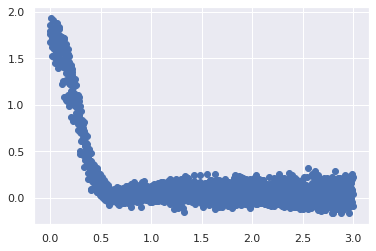

In [38]:
plt.scatter(test_data_t[:,0], test_y_t[:,2])

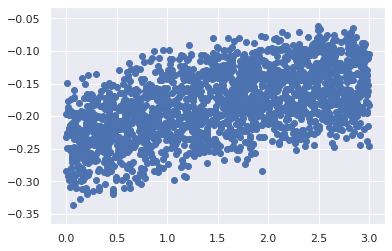

In [39]:
test_z = np.array(list(test_data[:][:,0]))[:,0]
test_zdot = test_preds[:,-1]
plt.scatter(test_z, test_zdot)

Average loss: 0.4578



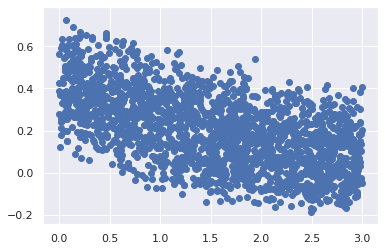

In [40]:
direct_test_preds, direct_test_var, direct_test_loss = demo_multi.test_regression(args, model, Myy, Myx, device, test_loader, mean0, var0)

plt.scatter(test_z, direct_test_preds[:,-1])

Text(0.5, 1.0, 'Robust Regression (RMSE: 0.265)')

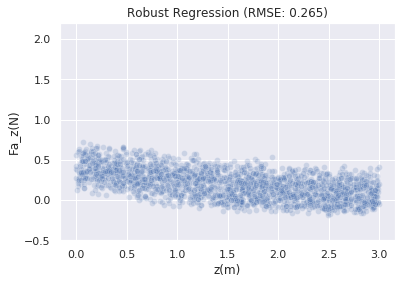

In [83]:
import seaborn as sns
sns.set(style="darkgrid")
syn_df = pd.DataFrame({
    'Fa_z(N)': direct_test_preds[:, -1],
    'z(m)': test_z
})
g = sns.scatterplot("z(m)", "Fa_z(N)", data=syn_df,
                    #xlim=(-0.2, 3.1), ylim=(-0.5, 2.2),
                    color="b",
                    #height=7,
                    #joint_kws={'alpha': 0.2}
                    alpha=0.2,
                   )

plt.ylim((-0.5, 2.2))
plt.title('Robust Regression (RMSE: 0.265)')

In [86]:
test_y_t[:,2]

tensor([ 0.3470, -0.0396,  0.2221,  ..., -0.0970,  0.1259, -0.0402])

Text(0.5, 1.0, 'Robust Regression (RMSE: 0.265)')

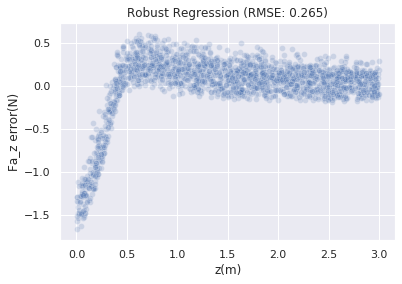

In [90]:
import seaborn as sns
sns.set(style="darkgrid")
syn_df = pd.DataFrame({
    'Fa_z error(N)': direct_test_preds[:, -1] - test_y_t[:,2].detach().numpy(),
    'z(m)': test_z
})
g = sns.scatterplot("z(m)", "Fa_z error(N)", data=syn_df,
                    #xlim=(-0.2, 3.1), ylim=(-0.5, 2.2),
                    color="b",
                    #height=7,
                    #joint_kws={'alpha': 0.2}
                    alpha=0.2,
                   )

plt.title('Robust Regression (RMSE: 0.265)')

In [96]:
np.quantile(direct_test_preds[:, -1] - test_y_t[:,2].detach().numpy(), 0.05)

-0.9951710764541694

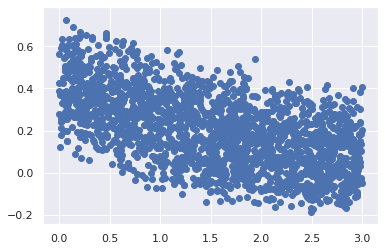

In [52]:
plt.scatter(test_z, y_pred[:, 2])

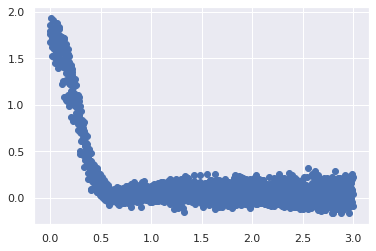

In [53]:
test_zdot_gt = np.array(list(test_data[:][:,1]))[:,-1]

plt.scatter(test_z, test_zdot_gt)

In [54]:
print(__doc__)

# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>s
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


mean0 and var0 is set according to prior knowledge and will not
affect the result a lot in the no shift case.
However, if there is shift and target data is far from source,
base distribution will dominate the result.




In [55]:
X = inputs.copy()[:1000]
x = np.zeros(X.shape)
x[:,0] = np.linspace(min(X[:,0]),max(X[:,0]), X.shape[0])
Y = dots.copy()[:1000]
dY = (0.5 + 1.0 * np.random.random(Y.shape)) * 0.1
noise = np.random.normal(0, dY)
Y += noise
print(X.shape, Y.shape, x.shape, dY.shape)

(1000, 4) (1000, 3) (1000, 4) (1000, 3)


In [56]:
n = X.shape[0]
X_train = X[:int(0.8 * n)]
X_test = X[int(0.8 * n):]
Y_train = Y[:int(0.8 * n)]
Y_test = Y[int(0.8 * n):]
dy_train = dY[:int(0.8 * n)]
dy_test = dY[int(0.8 * n):]
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(800, 4) (200, 4) (800, 3) (200, 3)


In [57]:
# Instantiate a Gaussian Process model
kernel = RBF(0.1)
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy_train[:,0] ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, Y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X_test, return_std=True)

In [58]:
np.sqrt(((Y_test - y_pred) ** 2).mean())

0.11312010192686324

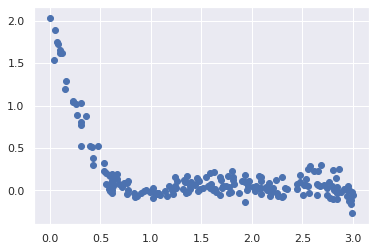

In [59]:
plt.scatter(X_test[:,0], y_pred[:,2])

Text(0.5, 1.0, 'Gaussian Process (RMSE: 0.120)')

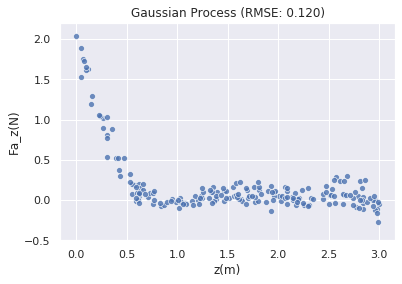

In [84]:
import seaborn as sns
sns.set(style="darkgrid")
syn_df = pd.DataFrame({
    'Fa_z(N)': y_pred[:,2],
    'z(m)': X_test[:, 0]
})
g = sns.scatterplot("z(m)", "Fa_z(N)", data=syn_df,
                    #xlim=(-0.2, 3.1), ylim=(-0.5, 2.2),
                    color="b",
                    #height=7,
                    #joint_kws={'alpha': 0.2}
                    alpha=0.8,
                   )

plt.ylim((-0.5, 2.2))
plt.title('Gaussian Process (RMSE: 0.120)')

In [99]:
np.quantile(y_pred[:,2] - Y_test[:,2], 0.95)

0.2154571357606839

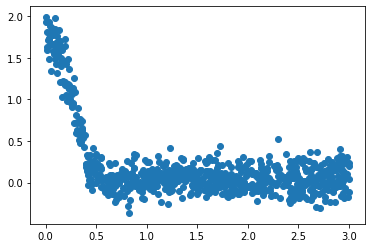

In [40]:
plt.scatter(X_train[:,0], Y_train[:,2])

In [41]:
# Instantiate a Gaussian Process model
gp_0 = GaussianProcessRegressor(kernel=kernel, alpha=dy_train[:,0] ** 2,
                              n_restarts_optimizer=10)
gp_1 = GaussianProcessRegressor(kernel=kernel, alpha=dy_train[:,0] ** 2,
                              n_restarts_optimizer=10)
gp_2 = GaussianProcessRegressor(kernel=kernel, alpha=dy_train[:,0] ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_0.fit(X_train, Y_train[:,0])
gp_1.fit(X_train, Y_train[:,1])
gp_2.fit(X_train, Y_train[:,2])

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred_0, sigma = gp_0.predict(X_test, return_std=True)
y_pred_1, sigma = gp_1.predict(X_test, return_std=True)
y_pred_2, sigma = gp_2.predict(X_test, return_std=True)

In [42]:
np.sqrt(((Y_test - np.vstack((y_pred_0, y_pred_1, y_pred_2)).T) ** 2).mean())

0.11978009622722825

Text(0.5, 1.0, '3D, Synthetic, GP, Test predictions')

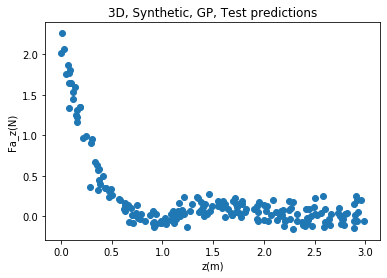

In [43]:
plt.scatter(X_test[:,0], y_pred[:,-1])

plt.xlabel('z(m)')
plt.ylabel('Fa_z(N)')
plt.title('3D, Synthetic, GP, Test predictions')

Text(0.5, 1.0, '3D, Synthetic, GP, Training data')

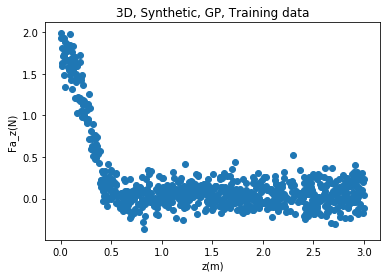

In [44]:
plt.scatter(X_train[:,0], Y_train[:,2])
plt.xlabel('z(m)')
plt.ylabel('Fa_z(N)')
plt.title('3D, Synthetic, GP, Training data')

In [45]:
n_rows = 10000
d_in = 8
d_out = 3
dots = np.zeros((n_rows, 3))
inputs = np.random.random(n_rows * d_in).reshape((n_rows, d_in))
inputs[:,0] *= 3
inputs[:,1:] = inputs[:,1:] * 2 - 1
for i, x in enumerate(inputs):
    a = fa_output(fa_model=fa_model, height=x[0],
                  velocity=x[1:4], controls=x[4:])
    dots[i] = a[0].detach().numpy()

In [46]:
class Args:
    pass

use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

batch_size = 32
epochs_training = 50
lr = 0.0005
momentum = 0.5
log_interval = 100
lamb = 0.001

args = Args()
args.batch_size = batch_size
args.epochs_training = epochs_training
args.lr = lr
args.momentum = momentum
args.log_interval = log_interval
split_data = SplitData(inputs, dots)

In [47]:
split_data = np.random.permutation(split_data)
train_data = data.Subset(split_data, range(0, int(0.8*len(split_data))))
# 20% test set
test_data = data.Subset(split_data, range(int(0.8*len(split_data)), len(split_data)))

m_train = len(train_data)

# for covariate shift, plug in densities for source data
weight_st = np.ones(m_train)
    
weighted_train = WeightDataSet(train_data, weight_st)
m_test = len(test_data)

# for covariate shift, plug in densities for target data
weight_st = np.ones(m_test)
weighted_test = WeightDataSet(test_data, weight_st)


test_loader = data.DataLoader(weighted_test,
    batch_size=args.batch_size, shuffle=False, **kwargs)

# 10% of training as validation
m_validate = int(0.1*m_train)

validate_loader = data.DataLoader(data.Subset(weighted_train,range(0, m_validate)),
    batch_size=args.batch_size, shuffle=False, **kwargs)

# 10% validation set, note that under shift cases, cannot valiate using training data
train_loader = data.DataLoader(data.Subset(weighted_train, range(m_validate, m_train)),
    batch_size=args.batch_size, shuffle=False, **kwargs)

base_model = Net(d_in, 256, d)
base_model = base_model.to(device)

print("entering training")
model, Myy, Myx, y_pred, y_var, _  = train_validate_test(
    args, args.epochs_training, device, use_cuda, base_model, 
    train_loader, test_loader , validate_loader, lamb)

entering training
Train Epoch: 1 [0/7200 (0%)]
Train Epoch: 1 [3200/7200 (44%)]
Train Epoch: 1 [6400/7200 (89%)]
gradient yy: 1.0702784624848605
gradient yx: 0.7778483329606289
Average loss: 0.1733

Train Epoch: 2 [0/7200 (0%)]
Train Epoch: 2 [3200/7200 (44%)]
Train Epoch: 2 [6400/7200 (89%)]
gradient yy: 0.9147474358049016
gradient yx: 0.6069426786058438
Average loss: 0.1557

Train Epoch: 3 [0/7200 (0%)]
Train Epoch: 3 [3200/7200 (44%)]
Train Epoch: 3 [6400/7200 (89%)]
gradient yy: 0.8111744174642268
gradient yx: 0.4789140165271745
Average loss: 0.1441

Train Epoch: 4 [0/7200 (0%)]
Train Epoch: 4 [3200/7200 (44%)]
Train Epoch: 4 [6400/7200 (89%)]
gradient yy: 0.7426366927420498
gradient yx: 0.38679746719505903
Average loss: 0.1365

Train Epoch: 5 [0/7200 (0%)]
Train Epoch: 5 [3200/7200 (44%)]
Train Epoch: 5 [6400/7200 (89%)]
gradient yy: 0.6947805819472846
gradient yx: 0.32184916195837554
Average loss: 0.1313

Train Epoch: 6 [0/7200 (0%)]
Train Epoch: 6 [3200/7200 (44%)]
Train Epoch: 

In [48]:
n = len(dots)
np.sqrt(((dots[int(len(dots) * 0.8):] - y_pred) ** 2).mean())

0.49937819795106864

In [49]:
X = inputs.copy()[:1000]
x = np.zeros(X.shape)
x[:,0] = np.linspace(min(X[:,0]),max(X[:,0]), X.shape[0])
Y = dots.copy()[:1000]
dY = (0.5 + 1.0 * np.random.random(Y.shape)) * 0.1
noise = np.random.normal(0, dY)
Y += noise
print(X.shape, Y.shape, x.shape, dY.shape)

(1000, 8) (1000, 3) (1000, 8) (1000, 3)


In [50]:
n = X.shape[0]
X_train = X[:int(0.8 * n)]
X_test = X[int(0.8 * n):]
Y_train = Y[:int(0.8 * n)]
Y_test = Y[int(0.8 * n):]
dy_train = dY[:int(0.8 * n)]
dy_test = dY[int(0.8 * n):]
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(800, 8) (200, 8) (800, 3) (200, 3)


In [51]:
# Instantiate a Gaussian Process model
kernel = RBF(0.01)
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy_train[:,0] ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, Y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X_test, return_std=True)

In [52]:
np.sqrt(((Y_test - y_pred) ** 2).mean())

0.14223583163742826

In [57]:
# Instantiate a Gaussian Process model
gp_0 = GaussianProcessRegressor(kernel=kernel, alpha=dy_train[:,0] ** 2,
                              n_restarts_optimizer=10)
gp_1 = GaussianProcessRegressor(kernel=kernel, alpha=dy_train[:,0] ** 2,
                              n_restarts_optimizer=10)
gp_2 = GaussianProcessRegressor(kernel=kernel, alpha=dy_train[:,0] ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_0.fit(X_train, Y_train[:,0])
gp_1.fit(X_train, Y_train[:,1])
gp_2.fit(X_train, Y_train[:,2])

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred_0, sigma = gp_0.predict(X_test, return_std=True)
y_pred_1, sigma = gp_1.predict(X_test, return_std=True)
y_pred_2, sigma = gp_2.predict(X_test, return_std=True)

In [58]:
np.sqrt(((Y_test - np.vstack((y_pred_0, y_pred_1, y_pred_2)).T) ** 2).mean())

0.13946106913603606

Text(0.5, 1.0, '3D, Synthetic, GP, Test predictions')

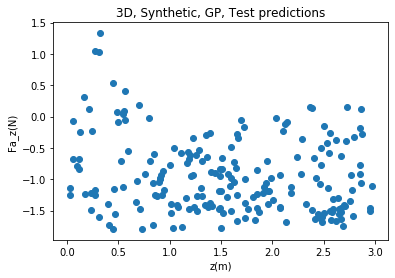

In [55]:
plt.scatter(X_test[:,0], y_pred[:,-1])

plt.xlabel('z(m)')
plt.ylabel('Fa_z(N)')
plt.title('3D, Synthetic, GP, Test predictions')

Text(0.5, 1.0, '3D, Synthetic, GP, Training data')

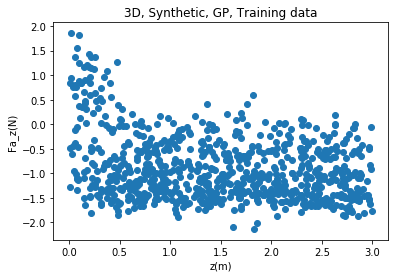

In [56]:
plt.scatter(X_train[:,0], Y_train[:,2])
plt.xlabel('z(m)')
plt.ylabel('Fa_z(N)')
plt.title('3D, Synthetic, GP, Training data')